In [1]:
#importing necessary libraries
from api.mapbox_api_walking import MapboxAPI
import requests
from urllib.request import urlopen
import json
from shapely.geometry import shape, Polygon
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('default')
import geopandas as gpd
import geodatasets
import ast
from shapely import wkt
from pyproj import Geod
from collections import defaultdict
from shapely.ops import unary_union

In [2]:
#reading in library branch and population demographics, both with geometry data
branchInfo = gpd.read_file('../data/clean/branches.csv')
censusTracts = pd.read_csv('../data/clean/population_demographics.csv')

In [3]:
censusTracts.shape

(869, 63)

In [4]:
branchInfo.loc[branchInfo['BRANCH'] == 'Roosevelt']

,BRANCH,HOURS OF OPERATION,ADDRESS,CITY,STATE,ZIP,PHONE,WEBSITE,LOCATION,PERMANENTLY_CLOSED,geometry
60,Roosevelt,,1101 W. Taylor Street,Chicago,IL,60607,,,"(41.86943838326072, -87.6544586134924)",1,None


In [5]:
branchInfo = branchInfo.drop([60,60])
branchInfo = branchInfo.set_index('BRANCH')
branchInfo = branchInfo.reset_index()
branchInfo

,BRANCH,HOURS OF OPERATION,ADDRESS,CITY,STATE,ZIP,PHONE,WEBSITE,LOCATION,PERMANENTLY_CLOSED,geometry
0,Albany Park,"Mon. & Wed., 10-6; Tues. & Thurs., Noon-8; Fri...",3401 W. Foster Ave.,Chicago,IL,60625,(773) 539-5450,https://www.chipublib.org/locations/3/,"(41.97557881655979, -87.71361314512697)",0,None
1,Altgeld,"Mon. & Wed., Noon-8; Tues. & Thurs., 10-6; Fri...",955 E. 131st Street,Chicago,IL,60827,(312) 747-3270,https://www.chipublib.org/locations/4/,"(41.65719847558056, -87.59883829075173)",0,None
2,Archer Heights,"Mon. & Wed., Noon-8; Tues. & Thurs., 10-6; Fri...",5055 S. Archer Ave.,Chicago,IL,60632,(312) 747-9241,https://www.chipublib.org/locations/5/,"(41.80110836194246, -87.72648385568911)",0,None
3,Austin,"Mon. & Wed., Noon-8; Tues. & Thurs., 10-6; Fri...",5615 W. Race Ave.,Chicago,IL,60644,(312) 746-5038,https://www.chipublib.org/locations/6/,"(41.88917312206642, -87.7658203582574)",0,None
4,Austin-Irving,"Mon. & Wed., Noon-8; Tues. & Thurs., 10-6; Fri...",6100 W. Irving Park Rd.,Chicago,IL,60634,(312) 744-6222,https://www.chipublib.org/locations/7/,"(41.95312267684315, -87.77928489355646)",0,None
...,...,...,...,...,...,...,...,...,...,...,...
76,West Pullman,"Mon. & Wed., Noon-8; Tue. & Thu., 10-6; Fri. &...",830 W. 119th St.,Chicago,IL,60643,(312) 747-1425,https://www.chipublib.org/locations/78/,"(41.67790647382097, -87.6431683153105)",0,None
77,West Town,"Mon. & Wed., 10-6; Tues. & Thurs., Noon-8; Fri...",1625 W. Chicago Ave.,Chicago,IL,60622,(312) 743-0450,https://www.chipublib.org/locations/79/,"(41.89594730478282, -87.66829305460979)",0,None
78,"Whitney M. Young, Jr.","Mon. & Wed., 10-6; Tues. & Thurs., Noon-8; Fri...",415 East 79th St.,Chicago,IL,60619,(312) 747-0039,https://www.chipublib.org/locations/80/,"(41.7510184591363, -87.61495065361933)",0,None
79,Woodson Regional Library,"Mon. - Thurs., 9-8; Fri. & Sat., 9-5; Sun., 1-5",9525 S. Halsted St.,Chicago,IL,60628,(312) 747-6900,https://www.chipublib.org/locations/81/,"(41.720694885749005, -87.64304817213312)",0,None


In [6]:
branchCopy = branchInfo

In [7]:
branchCopy[['Latitude', 'Longitude']] = [ast.literal_eval(x)[:2] for x in branchCopy['LOCATION']]
branchCopy = branchCopy.drop(columns='LOCATION')


In [8]:
#removing unecessary columns from branchInfo
branchInfo = branchInfo.drop(columns = ['HOURS OF OPERATION', 'ADDRESS', 'CITY', 'STATE', 'ZIP', 'PHONE', 'WEBSITE','PERMANENTLY_CLOSED'])
#removing unecessary columns from censusTracts
censusTracts = censusTracts[['geoid','geometry','qualifying name']]

In [9]:
#converting censusTracts to a geodataframe (we could not load it as one since it already had a geometry column so we are simply
#converting the geometry column to a proper gpd geometry column).
censusTracts = gpd.GeoDataFrame(
    censusTracts.loc[:, [c for c in censusTracts.columns if c != "geometry"]],
    geometry=gpd.GeoSeries.from_wkt(censusTracts["geometry"]),
    crs="epsg:4326",
    )

In [10]:
branchInfo[['LATITUDE', 'LONGITUDE']] = [ast.literal_eval(x)[:2] for x in branchInfo['LOCATION']]
branchInfo.loc[:, 'LATITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LATITUDE'])
branchInfo.loc[:, 'LONGITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LONGITUDE'])


In [11]:
#helper method to ensure that two polygons overlap before getting the intersection. Gets the intersection then calculates
#the percent of overlapping area for a census tract and saves it to a dictionary with the census tract geo-id as the key and
#the percent as the value.
def check(polygon1, df, geoname, dictionary, key, iso_dict, branchname):
    for i in range(len(df)):
        if polygon1.intersects(df.loc[i,geoname]): 
            
            overlapPolygon = (polygon1.intersection(df.loc[i,geoname]))
            iso_dict[df.loc[i, key]] = overlapPolygon
            poly_area, poly_perimeter = geod.geometry_area_perimeter(overlapPolygon)
            overlapArea = poly_area*-1
            propOverlap = overlapArea / df.loc[i,'Area']
            dictionary[df.loc[i, key]] = propOverlap
            
            
            if len(df.loc[i, 'polygons in census']) > 0:
                hold = (df.loc[i, 'polygons in census'][0]).copy()
                c = len(hold.items())
                hold[c] = overlapPolygon
                df.loc[i, 'polygons in census']= [hold]
                
                hold = (df.loc[i, 'area coverage of each polygon in census'][0]).copy()
                c = len(hold.items())
                hold[branchname] = propOverlap
                df.loc[i, 'area coverage of each polygon in census']= [hold]
 
 
            else:
                first = {0:overlapPolygon}
                df.loc[i, 'polygons in census'] = [first]
                
                first = {branchname:propOverlap}
                df.loc[i, 'area coverage of each polygon in census'] = [first]
            
    return dictionary


In [12]:
#sets the crs of gpd types
def geoSetup(gdf):
    
    gdf = gdf.set_crs('EPSG:4326')
    

In [13]:
#cdf = gdf of geometry area which you want to get the coverage score
#idf = gdf of points for which you want to get an isochrone and dictionary of percent of overlap in cdf areas
#scoreString = a string that is the name of the coverage score column you choose
#dictString = a string that is the name of the dictionary column you choose
#cgs = a string that is the name of the geometry column in the cdf
#igs = a string that is the name of the geometry column in the idf
#lat = a string that is the name of the latitude column in the idf
#lon = a string that is the name of the longitude column in the idf
#key = a string that is the name of the column in the cdf that you want to represent the key of the dictionary
#travelTime = an integer of the amount of time traveled you wish to calculate the isochrone

def appendADS(cdf, idf, scoreString, dictString, cgs, igs, lat, lon, key, travelTime):
    api = MapboxAPI()
    cdf[scoreString] = 0.0
    cdf['polygons in census'] = np.empty((len(cdf), 0)).tolist()
    cdf['area coverage of each polygon in census'] = np.empty((len(cdf), 0)).tolist()
    idf['number of census tracts reached'] = 0
    idf[dictString] = ''
    censusAreas = []
    global geod 
    geod = Geod(ellps='WGS84')
   
    geoSetup(cdf)
    geoSetup(idf)
   
    for index, row in cdf.iterrows():
        poly_area, poly_perimeter = geod.geometry_area_perimeter(row[cgs])
        poly_area = poly_area*-1
        censusAreas.append(poly_area)
    
    cdf['Area'] = censusAreas

    
   
    for i in range(len(idf)):
        # Create a new dictionary for tracking isochrones
        iso_dict = defaultdict(list)
        dictionary = {}
        api_response =  api.get_data((idf.loc[i,lat],idf.loc[i,lon]), travelTime)
        idf.loc[i,igs] = shape(api_response)
        dictionary = check(idf.loc[i,igs], cdf, cgs, dictionary, key, iso_dict, idf.loc[i,'BRANCH'])
        idf.loc[i,dictString] = [dictionary]
        idf.loc[i,'iso geometries'] = [iso_dict]
        idf.loc[i, 'number of census tracts reached'] = len(dictionary.items())
        
        for j in range(len(cdf)):
             if dictionary.get(cdf.loc[j, key]) != None:
                score = cdf.loc[j, scoreString]
                cdf.loc[j, scoreString] = score + dictionary.get(cdf.loc[j, key])
            
    for i in range(len(cdf)):
        if len(cdf.loc[i, 'polygons in census']) > 0:
            gl = []
            cdf.loc[i, 'number of polygons in census tract'] = len(cdf.loc[i, 'polygons in census'][0])
            toMerge = (cdf.loc[i, 'polygons in census'][0]).copy()
            for tract_key, polygons in toMerge.items():
                gl.append(polygons)
            merged_geom = unary_union(gl)
            merged_area, _ = geod.geometry_area_perimeter(merged_geom)
            merged_area *= -1
            area_val = merged_area / cdf.loc[i,'Area']
            cdf.loc[i, 'percent covered by at least one library'] = area_val
        
        if len(cdf.loc[i, 'area coverage of each polygon in census']) > 0:
            toAddPerc = 0
            toAdd = (cdf.loc[i, 'area coverage of each polygon in census'][0]).copy()
            for tract_key, percent in toAdd.items():
                toAddPerc = toAddPerc + percent
            cdf.loc[i, 'added percentages'] = toAddPerc
            
        else:
            cdf.loc[i, 'added percentages'] = 0
            cdf.loc[i, 'percent covered by at least one library'] = 0
            cdf.loc[i, 'number of polygons in census tract'] = 0
                
 

In [14]:
appendADS(censusTracts,branchInfo, 'raw score', 'list of dict','geometry','geometry','LATITUDE','LONGITUDE','geoid', 20)

In [15]:
branchInfo

,BRANCH,LOCATION,geometry,Latitude,Longitude,LATITUDE,LONGITUDE,number of census tracts reached,list of dict,iso geometries
0,Albany Park,"(41.97557881655979, -87.71361314512697)","POLYGON ((-87.71361 41.99099, -87.71475 41.990...",41.975579,-87.713613,41.975579,-87.713613,20,"[{17031140800: 0.24265316937897238, 1703104070...","{17031140800: POLYGON ((-87.704613 41.966282, ..."
1,Altgeld,"(41.65719847558056, -87.59883829075173)","POLYGON ((-87.59984 41.66669, -87.60132 41.666...",41.657198,-87.598838,41.657198,-87.598838,4,"[{17031540101: 0.2852409919978611, 17031550200...","[{17031540101: POLYGON ((-87.583838 41.652592,..."
2,Archer Heights,"(41.80110836194246, -87.72648385568911)","POLYGON ((-87.72348 41.81539, -87.72448 41.815...",41.801108,-87.726484,41.801108,-87.726484,16,"[{17031835200: 0.31115577131892175, 1703156030...","[{17031835200: POLYGON ((-87.738111 41.795481,..."
3,Austin,"(41.88917312206642, -87.7658203582574)","POLYGON ((-87.76582 41.90438, -87.76782 41.903...",41.889173,-87.765820,41.889173,-87.765820,18,"[{17031252101: 0.3298402493506001, 17031813000...","[{17031252101: POLYGON ((-87.76482 41.873971, ..."
4,Austin-Irving,"(41.95312267684315, -87.77928489355646)","POLYGON ((-87.77629 41.96628, -87.77729 41.966...",41.953123,-87.779285,41.953123,-87.779285,15,"[{17031190401: 0.006380952378444438, 170311512...","[{17031190401: POLYGON ((-87.778285 41.938009,..."
...,...,...,...,...,...,...,...,...,...,...
76,West Pullman,"(41.67790647382097, -87.6431683153105)","POLYGON ((-87.64217 41.69264, -87.64517 41.690...",41.677906,-87.643168,41.677906,-87.643168,14,"[{17031821402: 0.06683673133829206, 1703182120...",[{17031821402: MULTIPOLYGON (((-87.65133916424...
77,West Town,"(41.89594730478282, -87.66829305460979)","POLYGON ((-87.66729 41.91086, -87.66829 41.910...",41.895947,-87.668293,41.895947,-87.668293,26,"[{17031838100: 0.06635765522527748, 1703183310...","[{17031838100: POLYGON ((-87.667293 41.881007,..."
78,"Whitney M. Young, Jr.","(41.7510184591363, -87.61495065361933)","POLYGON ((-87.61495 41.76667, -87.61657 41.766...",41.751018,-87.614951,41.751018,-87.614951,19,"[{17031440700: 0.02826420162848117, 1703144020...","[{17031440700: POLYGON ((-87.613951 41.735668,..."
79,Woodson Regional Library,"(41.720694885749005, -87.64304817213312)","POLYGON ((-87.64305 41.73608, -87.64405 41.736...",41.720695,-87.643048,41.720695,-87.643048,16,"[{17031490500: 0.0004301774341055276, 17031491...","[{17031490500: POLYGON ((-87.623164 41.721695,..."


In [29]:
file_path = '../data/clean/branchDataWithReachCount.csv'

branchInfo.to_csv(file_path, index=False)

In [16]:
censusTracts

,geoid,qualifying name,geometry,raw score,polygons in census,area coverage of each polygon in census,Area,added percentages,percent covered by at least one library,number of polygons in census tract
0,17031823303,"Census Tract 8233.03, Cook County, Illinois","POLYGON ((-87.72096 41.68395, -87.72030 41.683...",0.000000,[],[],1.081697e+00,0.000000,0.000000,0.0
1,17031823304,"Census Tract 8233.04, Cook County, Illinois","MULTIPOLYGON (((-87.72004 41.68397, -87.72006 ...",1.075668,"[{0: MULTIPOLYGON (((-87.691025 41.684568, -87...","[{'Mount Greenwood': 0.9776923144788833, 'Walk...",3.526503e+05,1.075668,0.977695,2.0
2,17031740400,"Census Tract 7404, Cook County, Illinois","POLYGON ((-87.72008 41.69127, -87.71937 41.691...",0.366605,"[{0: POLYGON ((-87.706108 41.681016, -87.70981...",[{'Mount Greenwood': 0.36660493380788106}],2.782659e+06,0.366605,0.366605,1.0
3,17031740300,"Census Tract 7403, Cook County, Illinois","POLYGON ((-87.72043 41.69857, -87.72007 41.698...",0.879500,"[{0: POLYGON ((-87.719025 41.69501, -87.716715...",[{'Mount Greenwood': 0.8795001443669833}],1.319688e+06,0.879500,0.879500,1.0
4,17031822802,"Census Tract 8228.02, Cook County, Illinois","MULTIPOLYGON (((-87.72075 41.70204, -87.72075 ...",0.018157,[{0: POLYGON ((-87.72038547840123 41.692511380...,[{'Mount Greenwood': 0.018157412351250023}],1.577396e+01,0.018157,0.018157,1.0
...,...,...,...,...,...,...,...,...,...,...
864,17031320400,"Census Tract 3204, Cook County, Illinois","POLYGON ((-87.62764 41.88206, -87.62759 41.882...",1.000000,"[{0: POLYGON ((-87.627594 41.882062, -87.62712...",[{'Harold Washington Library Center': 1.0}],8.033379e+05,1.000000,1.000000,1.0
865,17031320101,"Census Tract 3201.01, Cook County, Illinois","POLYGON ((-87.62086 41.88188, -87.62082 41.882...",0.747717,"[{0: POLYGON ((-87.620108 41.887551, -87.61820...",[{'Harold Washington Library Center': 0.512544...,4.902799e+05,0.747717,0.682407,2.0
866,17031081403,"Census Tract 814.03, Cook County, Illinois","MULTIPOLYGON (((-87.62431 41.88911, -87.62431 ...",0.709643,"[{0: POLYGON ((-87.623797 41.890674, -87.62226...",[{'Harold Washington Library Center': 0.032475...,5.956278e+05,0.709643,0.677168,2.0
867,17031081402,"Census Tract 814.02, Cook County, Illinois","POLYGON ((-87.61754 41.89345, -87.61716 41.893...",0.466886,"[{0: POLYGON ((-87.610425 41.889532, -87.61114...",[{'Water Works': 0.46688602377910954}],5.776787e+05,0.466886,0.466886,1.0


In [17]:
censusTracts.sort_values(by = 'number of polygons in census tract', ascending = False)

,geoid,qualifying name,geometry,raw score,polygons in census,area coverage of each polygon in census,Area,added percentages,percent covered by at least one library,number of polygons in census tract
318,17031842600,"Census Tract 8426, Cook County, Illinois","POLYGON ((-87.66537 41.82315, -87.66480 41.823...",0.863979,"[{0: POLYGON ((-87.66457 41.81484, -87.663758 ...","[{'Back of the Yards': 0.06271765050593388, 'C...",3.679425e+06,0.863979,0.737352,7.0
399,17031833100,"Census Tract 8331, Cook County, Illinois","POLYGON ((-87.66680 41.88146, -87.66670 41.881...",1.999500,"[{0: POLYGON ((-87.647504 41.876863, -87.64722...",[{'Harold Washington Library Center': 0.001091...,9.228165e+05,1.999500,1.000000,5.0
835,17031040100,"Census Tract 401, Cook County, Illinois","POLYGON ((-87.68942 41.99050, -87.68904 41.990...",0.641735,"[{0: POLYGON ((-87.67562 41.976551, -87.674447...","[{'Bezazian': 0.005390885362964395, 'Budlong W...",2.001672e+06,0.641735,0.611698,5.0
622,17031842300,"Census Tract 8423, Cook County, Illinois","POLYGON ((-87.66748 41.91435, -87.66726 41.914...",0.641109,"[{0: POLYGON ((-87.666321 41.913376, -87.66564...","[{'Bucktown-Wicker Park': 0.09311685447779602,...",1.877677e+06,0.641109,0.619132,5.0
365,17031841900,"Census Tract 8419, Cook County, Illinois","POLYGON ((-87.65164 41.87660, -87.65094 41.876...",0.868584,"[{0: POLYGON ((-87.644952 41.860121, -87.64254...","[{'Chinatown': 0.10695843461114603, 'Harold Wa...",2.564524e+06,0.868584,0.695470,5.0
...,...,...,...,...,...,...,...,...,...,...
453,17031831400,"Census Tract 8314, Cook County, Illinois","POLYGON ((-87.77413 41.87091, -87.77400 41.870...",0.000000,[],[],2.104176e+06,0.000000,0.000000,0.0
452,17031813302,"Census Tract 8133.02, Cook County, Illinois","MULTIPOLYGON (((-87.74960 41.86583, -87.74964 ...",0.000000,[],[],2.022143e+03,0.000000,0.000000,0.0
441,17031813301,"Census Tract 8133.01, Cook County, Illinois","MULTIPOLYGON (((-87.75843 41.86569, -87.75786 ...",0.000000,[],[],1.221551e+01,0.000000,0.000000,0.0
440,17031813400,"Census Tract 8134, Cook County, Illinois","MULTIPOLYGON (((-87.77287 41.86548, -87.77290 ...",0.000000,[],[],7.897302e+00,0.000000,0.000000,0.0


In [18]:
censusTracts.sort_values(by = 'percent covered by at least one library', ascending = False)

,geoid,qualifying name,geometry,raw score,polygons in census,area coverage of each polygon in census,Area,added percentages,percent covered by at least one library,number of polygons in census tract
685,17031061800,"Census Tract 618, Cook County, Illinois","POLYGON ((-87.64920 41.94731, -87.64904 41.947...",1.992832,"[{0: POLYGON ((-87.649043 41.947306, -87.64800...","[{'Merlo': 1.0, 'Uptown': 0.9928320190348365}]",8.276871e+04,1.992832,1.0,2.0
490,17031251700,"Census Tract 2517, Cook County, Illinois","POLYGON ((-87.74777 41.89499, -87.74735 41.894...",1.082580,"[{0: POLYGON ((-87.746232 41.889173, -87.74686...","[{'Austin': 0.0825797733002823, 'West Chicago ...",4.866559e+05,1.082580,1.0,2.0
335,17031360200,"Census Tract 3602, Cook County, Illinois","POLYGON ((-87.61242 41.82465, -87.61237 41.824...",1.732138,"[{0: POLYGON ((-87.608206 41.826243, -87.60935...","[{'Chicago Bee': 0.7321375670028607, 'King': 1...",2.320449e+05,1.732138,1.0,2.0
86,17031711300,"Census Tract 7113, Cook County, Illinois","POLYGON ((-87.67285 41.73565, -87.67279 41.735...",1.451306,"[{0: POLYGON ((-87.666146 41.734179, -87.66514...","[{'Beverly': 0.45130630392912313, 'Brainerd': ...",3.500174e+05,1.451306,1.0,2.0
326,17031840000,"Census Tract 8400, Cook County, Illinois","POLYGON ((-87.64117 41.83811, -87.64044 41.838...",1.918725,"[{0: POLYGON ((-87.639568 41.829621, -87.63728...","[{'Canaryville': 0.2794627068109991, 'Chicago ...",5.693939e+05,1.918725,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...
453,17031831400,"Census Tract 8314, Cook County, Illinois","POLYGON ((-87.77413 41.87091, -87.77400 41.870...",0.000000,[],[],2.104176e+06,0.000000,0.0,0.0
452,17031813302,"Census Tract 8133.02, Cook County, Illinois","MULTIPOLYGON (((-87.74960 41.86583, -87.74964 ...",0.000000,[],[],2.022143e+03,0.000000,0.0,0.0
441,17031813301,"Census Tract 8133.01, Cook County, Illinois","MULTIPOLYGON (((-87.75843 41.86569, -87.75786 ...",0.000000,[],[],1.221551e+01,0.000000,0.0,0.0
440,17031813400,"Census Tract 8134, Cook County, Illinois","MULTIPOLYGON (((-87.77287 41.86548, -87.77290 ...",0.000000,[],[],7.897302e+00,0.000000,0.0,0.0


In [19]:
censusTracts['raw score norm'] = censusTracts['raw score']
censusTracts.loc[censusTracts['raw score norm'] > 1, 'raw score norm'] = 1.0
censusTracts['weighted score'] = censusTracts['number of polygons in census tract'] * censusTracts['percent covered by at least one library']
censusTracts.sort_values(by = 'weighted score', ascending = False)

,geoid,qualifying name,geometry,raw score,polygons in census,area coverage of each polygon in census,Area,added percentages,percent covered by at least one library,number of polygons in census tract,raw score norm,weighted score
318,17031842600,"Census Tract 8426, Cook County, Illinois","POLYGON ((-87.66537 41.82315, -87.66480 41.823...",0.863979,"[{0: POLYGON ((-87.66457 41.81484, -87.663758 ...","[{'Back of the Yards': 0.06271765050593388, 'C...",3.679425e+06,0.863979,0.737352,7.0,0.863979,5.161463
399,17031833100,"Census Tract 8331, Cook County, Illinois","POLYGON ((-87.66680 41.88146, -87.66670 41.881...",1.999500,"[{0: POLYGON ((-87.647504 41.876863, -87.64722...",[{'Harold Washington Library Center': 0.001091...,9.228165e+05,1.999500,1.000000,5.0,1.000000,5.000000
326,17031840000,"Census Tract 8400, Cook County, Illinois","POLYGON ((-87.64117 41.83811, -87.64044 41.838...",1.918725,"[{0: POLYGON ((-87.639568 41.829621, -87.63728...","[{'Canaryville': 0.2794627068109991, 'Chicago ...",5.693939e+05,1.918725,1.000000,4.0,1.000000,4.000000
501,17031230200,"Census Tract 2302, Cook County, Illinois","POLYGON ((-87.71309 41.91359, -87.71301 41.913...",1.058900,"[{0: POLYGON ((-87.707384 41.910255, -87.70684...","[{'Daley, Richard M. - W. Humboldt': 0.0029004...",2.142864e+05,1.058900,1.000000,4.0,1.000000,4.000000
320,17031380600,"Census Tract 3806, Cook County, Illinois","POLYGON ((-87.62931 41.82368, -87.62928 41.823...",2.221772,"[{0: POLYGON ((-87.622643 41.817344, -87.62228...","[{'Canaryville': 0.2323269626621201, 'Chicago ...",8.388936e+05,2.221772,1.000000,4.0,1.000000,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
453,17031831400,"Census Tract 8314, Cook County, Illinois","POLYGON ((-87.77413 41.87091, -87.77400 41.870...",0.000000,[],[],2.104176e+06,0.000000,0.000000,0.0,0.000000,0.000000
452,17031813302,"Census Tract 8133.02, Cook County, Illinois","MULTIPOLYGON (((-87.74960 41.86583, -87.74964 ...",0.000000,[],[],2.022143e+03,0.000000,0.000000,0.0,0.000000,0.000000
441,17031813301,"Census Tract 8133.01, Cook County, Illinois","MULTIPOLYGON (((-87.75843 41.86569, -87.75786 ...",0.000000,[],[],1.221551e+01,0.000000,0.000000,0.0,0.000000,0.000000
440,17031813400,"Census Tract 8134, Cook County, Illinois","MULTIPOLYGON (((-87.77287 41.86548, -87.77290 ...",0.000000,[],[],7.897302e+00,0.000000,0.000000,0.0,0.000000,0.000000


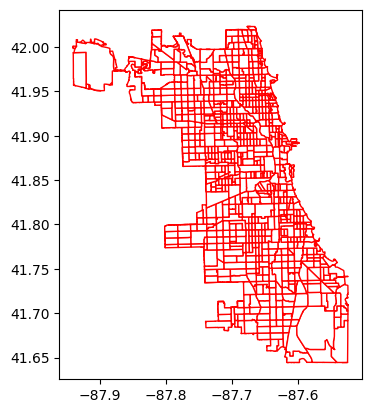

In [20]:
branchCopy = gpd.GeoDataFrame(
     branchCopy, geometry=gpd.points_from_xy(branchCopy.Longitude, branchCopy.Latitude), crs="EPSG:3435")

base = censusTracts.plot(color='white', edgecolor='red')


<Axes: title={'center': 'Raw Score'}>

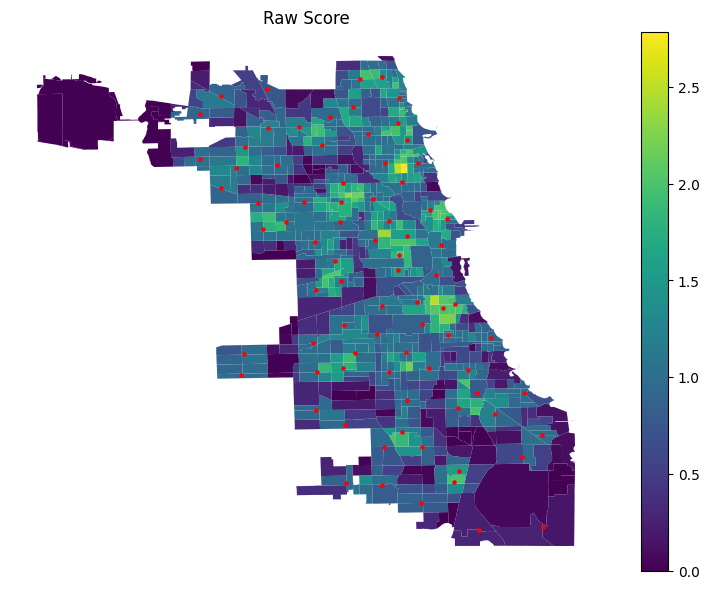

In [21]:
ax = censusTracts.plot(column = 'raw score', legend = True, 
                figsize=(10,7),missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "Missing values",
    })


ax.set_axis_off()
ax.set_title("Raw Score")
branchCopy.plot(ax=ax, marker='o', color='red', markersize=5, edgecolor='red')


<Axes: title={'center': 'Raw Score Normalized'}>

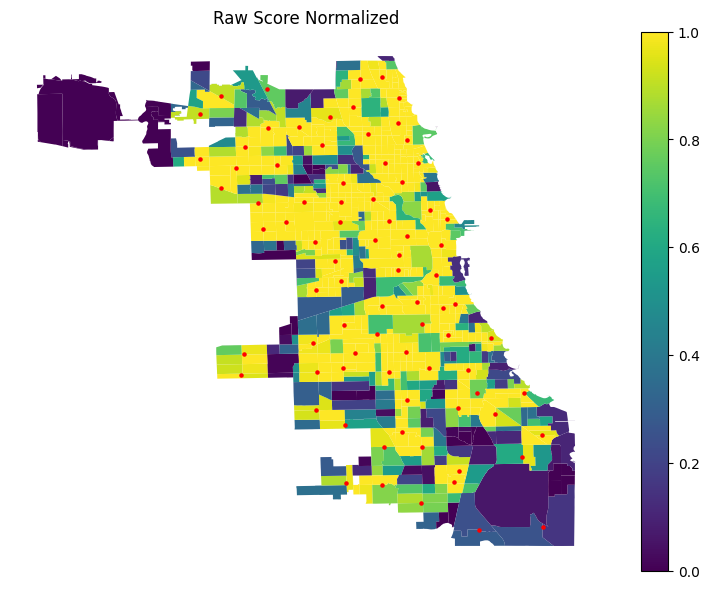

In [22]:
ax = censusTracts.plot(column = 'raw score norm', legend = True, 
                figsize=(10,7),missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "Missing values",
    })


ax.set_axis_off()
ax.set_title("Raw Score Normalized")
branchCopy.plot(ax=ax, marker='o', color='red', markersize=5, edgecolor='red')


<Axes: title={'center': 'Percent of access to at least one library'}>

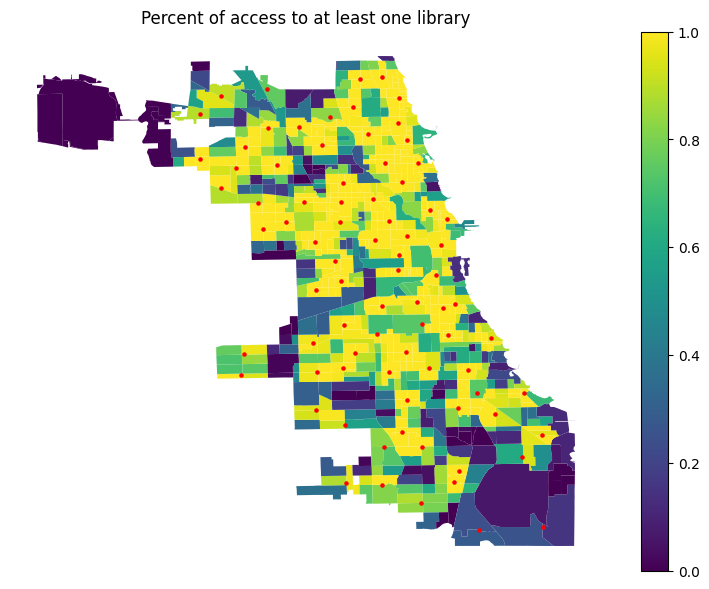

In [23]:
ax = censusTracts.plot(column = 'percent covered by at least one library', legend = True, 
                figsize=(10,7),missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "Missing values",
    })


ax.set_axis_off()
ax.set_title("Percent of access to at least one library")
branchCopy.plot(ax=ax, marker='o', color='red', markersize=5)


<Axes: title={'center': 'Weighted Score'}>

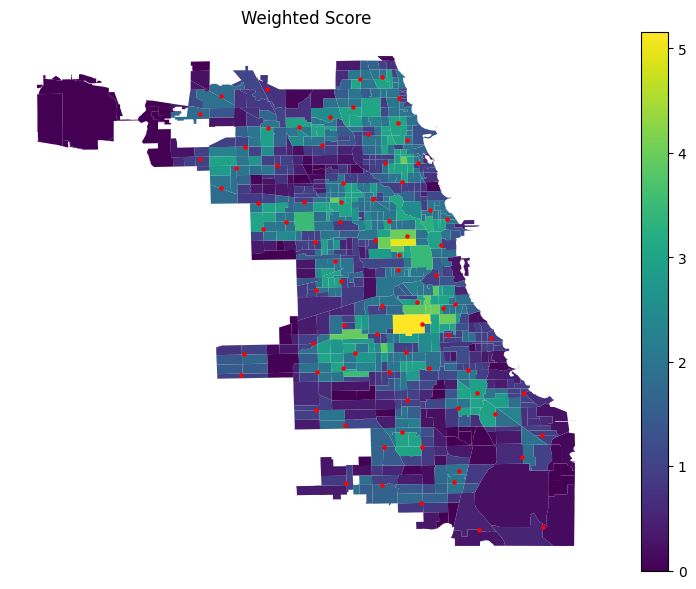

In [24]:
ax = censusTracts.plot(column = 'weighted score', legend = True, 
                figsize=(10,7),missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "Missing values",
    })


ax.set_axis_off()
ax.set_title("Weighted Score")
branchCopy.plot(ax=ax, marker='o', color='red', markersize=5)


In [25]:
demographics = pd.read_csv('../data/clean/census_demos.csv')
demographics

,geoid,qualifying name,geometry,total population,Percent: under 5 years,Percent: 5 to 9 years,Percent: 10 to 14 years,Percent: 15 to 19 years,Percent: 20 to 24 years,Percent: 25 to 29 years,...,Percent of People with Computers,Percent of People without Computers,Percent of People with Computers and Internet,Percent: White Alone,Percent: Black or African American Alone,Percent: American Indian and Alaska Native Alone,Percent: Asian Alone,Percent: Native Hawaiian and Other Pacific Islander Alone,Percent: Some Other Race Alone,Percent: Two or More Races
0,17031823303,"Census Tract 8233.03, Cook County, Illinois","POLYGON ((-87.720963 41.683952, -87.720304 41....",4059,0.047056,0.099039,0.075634,0.052230,0.040404,0.069475,...,0.912801,0.087199,0.806432,0.795763,0.078098,0.009855,0.000000,0.0,0.072924,0.043360
1,17031823304,"Census Tract 8233.04, Cook County, Illinois",MULTIPOLYGON (((-87.72003618903081 41.68396731...,6316,0.060798,0.063965,0.094205,0.057948,0.056365,0.066498,...,0.787775,0.212225,0.691724,0.603388,0.304465,0.001742,0.008233,0.0,0.037365,0.044807
2,17031740400,"Census Tract 7404, Cook County, Illinois","POLYGON ((-87.72008 41.691274, -87.719372 41.6...",4738,0.067750,0.060996,0.082946,0.063529,0.068383,0.064373,...,0.918216,0.081784,0.836431,0.879907,0.058041,0.000000,0.032714,0.0,0.000000,0.029337
3,17031740300,"Census Tract 7403, Cook County, Illinois","POLYGON ((-87.720431 41.698569, -87.720066 41....",5017,0.068567,0.073749,0.069962,0.042456,0.028304,0.067570,...,0.948943,0.051057,0.929345,0.906119,0.015547,0.000000,0.008372,0.0,0.033486,0.036476
4,17031822802,"Census Tract 8228.02, Cook County, Illinois","MULTIPOLYGON (((-87.720752 41.702042, -87.7207...",3750,0.055200,0.114667,0.068000,0.081600,0.030933,0.027467,...,0.885246,0.114754,0.850898,0.849067,0.049333,0.001333,0.018933,0.0,0.022400,0.058933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864,17031320400,"Census Tract 3204, Cook County, Illinois","POLYGON ((-87.627636 41.882057, -87.627594 41....",3058,0.003924,0.003597,0.000000,0.300523,0.325049,0.050033,...,NaN,NaN,0.904269,0.678548,0.107914,0.000000,0.149444,0.0,0.015043,0.049052
865,17031320101,"Census Tract 3201.01, Cook County, Illinois","POLYGON ((-87.620855 41.881881, -87.620825 41....",7952,0.026157,0.038481,0.005282,0.020372,0.032193,0.095825,...,0.953413,0.046587,0.791776,0.594693,0.067404,0.000000,0.234406,0.0,0.053697,0.049799
866,17031081403,"Census Tract 814.03, Cook County, Illinois","MULTIPOLYGON (((-87.624311 41.889115, -87.6243...",8984,0.028718,0.002894,0.005677,0.000000,0.108081,0.220837,...,0.996585,0.003415,0.920150,0.616874,0.019368,0.000000,0.306879,0.0,0.025378,0.031500
867,17031081402,"Census Tract 814.02, Cook County, Illinois","POLYGON ((-87.617537 41.893453, -87.617164 41....",5613,0.051309,0.042936,0.010868,0.012649,0.055407,0.155175,...,0.969296,0.030704,0.918122,0.619277,0.049172,0.003029,0.240869,0.0,0.018172,0.069482


In [26]:
censusTracts = censusTracts.drop(columns = ['qualifying name','geometry'])
censusTracts

,geoid,raw score,polygons in census,area coverage of each polygon in census,Area,added percentages,percent covered by at least one library,number of polygons in census tract,raw score norm,weighted score
0,17031823303,0.000000,[],[],1.081697e+00,0.000000,0.000000,0.0,0.000000,0.000000
1,17031823304,1.075668,"[{0: MULTIPOLYGON (((-87.691025 41.684568, -87...","[{'Mount Greenwood': 0.9776923144788833, 'Walk...",3.526503e+05,1.075668,0.977695,2.0,1.000000,1.955389
2,17031740400,0.366605,"[{0: POLYGON ((-87.706108 41.681016, -87.70981...",[{'Mount Greenwood': 0.36660493380788106}],2.782659e+06,0.366605,0.366605,1.0,0.366605,0.366605
3,17031740300,0.879500,"[{0: POLYGON ((-87.719025 41.69501, -87.716715...",[{'Mount Greenwood': 0.8795001443669833}],1.319688e+06,0.879500,0.879500,1.0,0.879500,0.879500
4,17031822802,0.018157,[{0: POLYGON ((-87.72038547840123 41.692511380...,[{'Mount Greenwood': 0.018157412351250023}],1.577396e+01,0.018157,0.018157,1.0,0.018157,0.018157
...,...,...,...,...,...,...,...,...,...,...
864,17031320400,1.000000,"[{0: POLYGON ((-87.627594 41.882062, -87.62712...",[{'Harold Washington Library Center': 1.0}],8.033379e+05,1.000000,1.000000,1.0,1.000000,1.000000
865,17031320101,0.747717,"[{0: POLYGON ((-87.620108 41.887551, -87.61820...",[{'Harold Washington Library Center': 0.512544...,4.902799e+05,0.747717,0.682407,2.0,0.747717,1.364814
866,17031081403,0.709643,"[{0: POLYGON ((-87.623797 41.890674, -87.62226...",[{'Harold Washington Library Center': 0.032475...,5.956278e+05,0.709643,0.677168,2.0,0.709643,1.354336
867,17031081402,0.466886,"[{0: POLYGON ((-87.610425 41.889532, -87.61114...",[{'Water Works': 0.46688602377910954}],5.776787e+05,0.466886,0.466886,1.0,0.466886,0.466886


In [27]:
censusTracts.merge(demographics, on = 'geoid')

,geoid,raw score,polygons in census,area coverage of each polygon in census,Area,added percentages,percent covered by at least one library,number of polygons in census tract,raw score norm,weighted score,...,Percent of People with Computers,Percent of People without Computers,Percent of People with Computers and Internet,Percent: White Alone,Percent: Black or African American Alone,Percent: American Indian and Alaska Native Alone,Percent: Asian Alone,Percent: Native Hawaiian and Other Pacific Islander Alone,Percent: Some Other Race Alone,Percent: Two or More Races
0,17031823303,0.000000,[],[],1.081697e+00,0.000000,0.000000,0.0,0.000000,0.000000,...,0.912801,0.087199,0.806432,0.795763,0.078098,0.009855,0.000000,0.0,0.072924,0.043360
1,17031823304,1.075668,"[{0: MULTIPOLYGON (((-87.691025 41.684568, -87...","[{'Mount Greenwood': 0.9776923144788833, 'Walk...",3.526503e+05,1.075668,0.977695,2.0,1.000000,1.955389,...,0.787775,0.212225,0.691724,0.603388,0.304465,0.001742,0.008233,0.0,0.037365,0.044807
2,17031740400,0.366605,"[{0: POLYGON ((-87.706108 41.681016, -87.70981...",[{'Mount Greenwood': 0.36660493380788106}],2.782659e+06,0.366605,0.366605,1.0,0.366605,0.366605,...,0.918216,0.081784,0.836431,0.879907,0.058041,0.000000,0.032714,0.0,0.000000,0.029337
3,17031740300,0.879500,"[{0: POLYGON ((-87.719025 41.69501, -87.716715...",[{'Mount Greenwood': 0.8795001443669833}],1.319688e+06,0.879500,0.879500,1.0,0.879500,0.879500,...,0.948943,0.051057,0.929345,0.906119,0.015547,0.000000,0.008372,0.0,0.033486,0.036476
4,17031822802,0.018157,[{0: POLYGON ((-87.72038547840123 41.692511380...,[{'Mount Greenwood': 0.018157412351250023}],1.577396e+01,0.018157,0.018157,1.0,0.018157,0.018157,...,0.885246,0.114754,0.850898,0.849067,0.049333,0.001333,0.018933,0.0,0.022400,0.058933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864,17031320400,1.000000,"[{0: POLYGON ((-87.627594 41.882062, -87.62712...",[{'Harold Washington Library Center': 1.0}],8.033379e+05,1.000000,1.000000,1.0,1.000000,1.000000,...,NaN,NaN,0.904269,0.678548,0.107914,0.000000,0.149444,0.0,0.015043,0.049052
865,17031320101,0.747717,"[{0: POLYGON ((-87.620108 41.887551, -87.61820...",[{'Harold Washington Library Center': 0.512544...,4.902799e+05,0.747717,0.682407,2.0,0.747717,1.364814,...,0.953413,0.046587,0.791776,0.594693,0.067404,0.000000,0.234406,0.0,0.053697,0.049799
866,17031081403,0.709643,"[{0: POLYGON ((-87.623797 41.890674, -87.62226...",[{'Harold Washington Library Center': 0.032475...,5.956278e+05,0.709643,0.677168,2.0,0.709643,1.354336,...,0.996585,0.003415,0.920150,0.616874,0.019368,0.000000,0.306879,0.0,0.025378,0.031500
867,17031081402,0.466886,"[{0: POLYGON ((-87.610425 41.889532, -87.61114...",[{'Water Works': 0.46688602377910954}],5.776787e+05,0.466886,0.466886,1.0,0.466886,0.466886,...,0.969296,0.030704,0.918122,0.619277,0.049172,0.003029,0.240869,0.0,0.018172,0.069482
